In [1]:
import pandas as pd
sales = pd.read_excel('Datos_examen_final_17Co2024_Grupo4.xlsx', sheet_name='Santa Ana')
sales["Mes"] = sales["Fecha"].dt.month # alternativa: dt.month_name()
# sales["DiaDeSemana"] = sales["Fecha"].dt.weekday
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   365 non-null    datetime64[ns]
 1   Ventas  365 non-null    float64       
 2   Mes     365 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 7.3 KB


## Ventas por mes en supermercado 'Santa Ana'

In [2]:
import matplotlib.pyplot as plt
import math
def plot_sales(data, plot_fun,title, n = 3, pad = 2.0, fig_size = (10,10)):
    m = math.ceil(len(data)/n)
    figure, axis = plt.subplots(m,n, figsize=fig_size)
    figure.tight_layout(pad = pad)
    for i in range(m*n):
        row = i//n
        col = i%n
        if i < len(data):
            axis[row][col].set_title(f"{title}: {i+1}")
            plot_fun(data[i], axis[row][col])
        else: 
            axis[row][col].axis('off')
            
sales_per_month = [sales[sales["Mes"] == (i+1)]["Ventas"].values for i in range(12)]

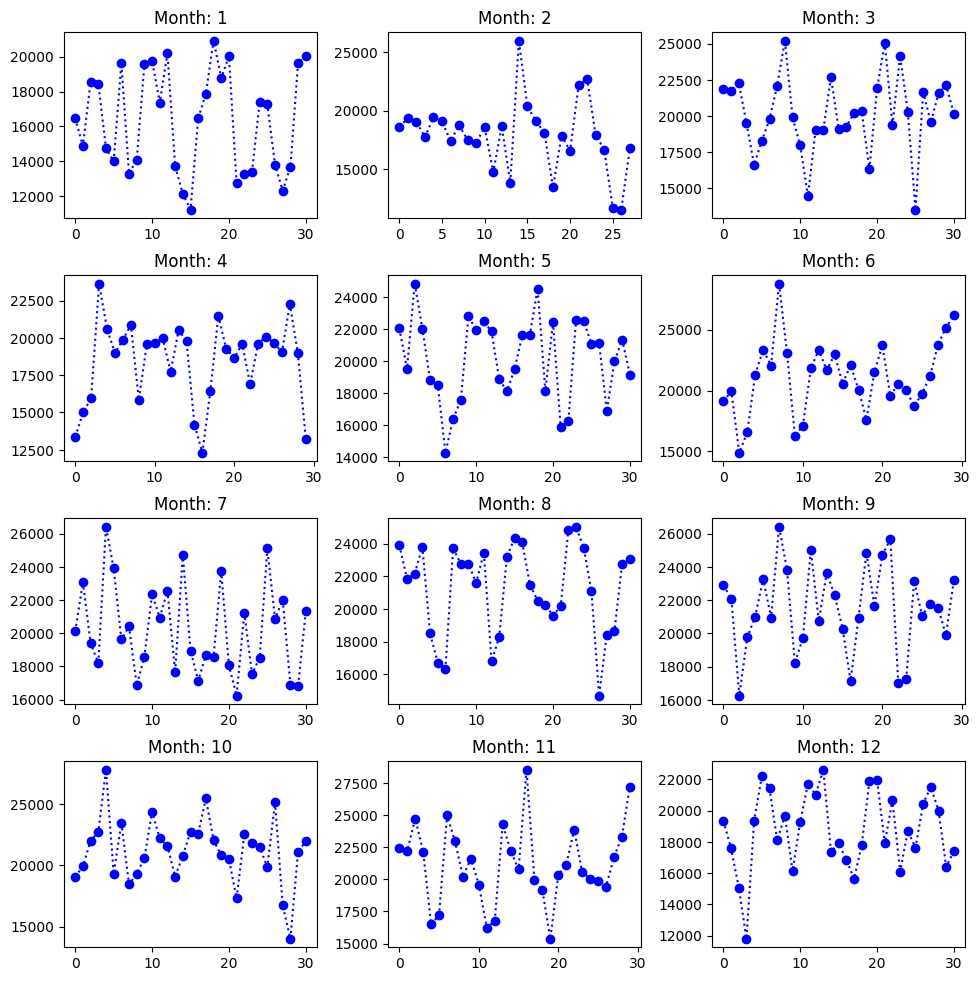

In [3]:
def month_sale_plot_fun(data, ax):    
    ax.plot(range(len(data)), data, color='blue', linestyle=':', marker='o')
plot_sales(sales_per_month,  month_sale_plot_fun , title='Month')

## 1 . Determinen intervalos de confianza empíricos para el supermercado 'Santa Ana' en cada mes, para siginificancias del 95% y el 99%.

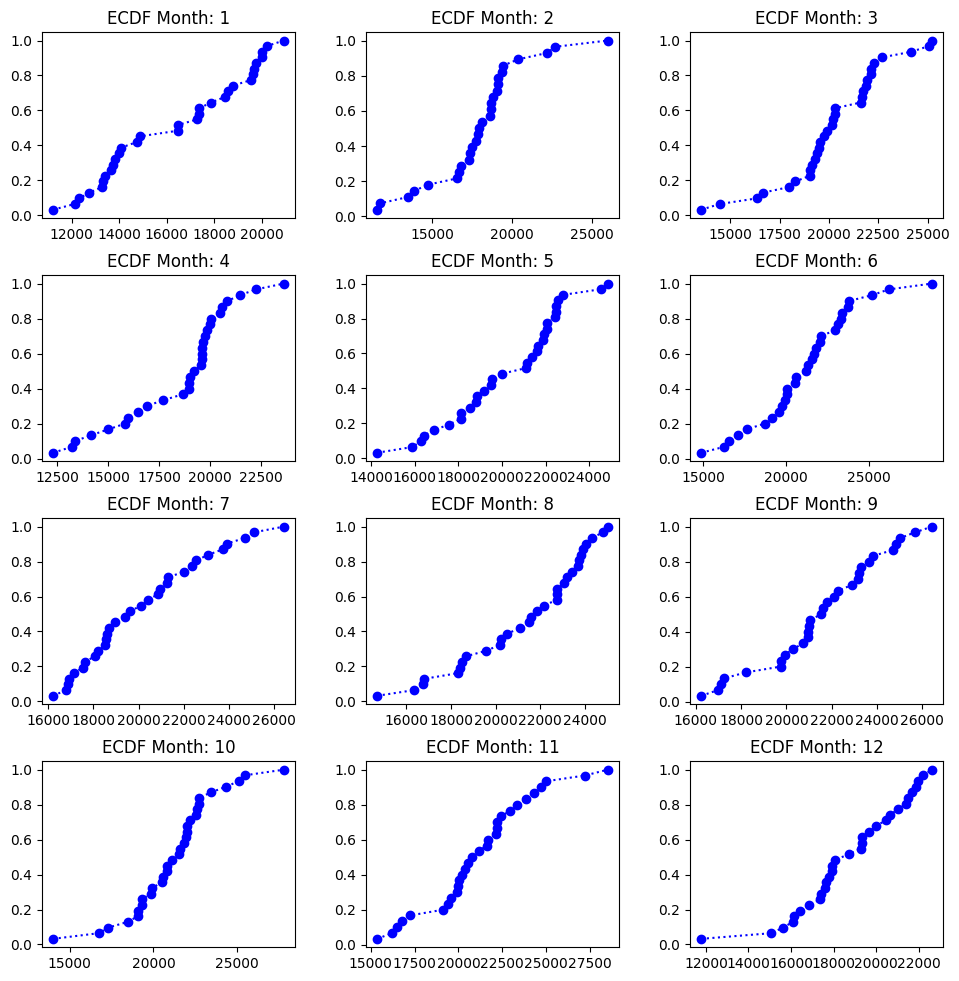

In [4]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf_per_month= list(map(lambda x: ECDF(x), sales_per_month))
def month_ecdf_plot_fun(data, ax):    
    # print('data:', data)
    ax.plot(data.x, data.y, color='blue', linestyle=':', marker='o')
plot_sales(ecdf_per_month,  month_ecdf_plot_fun , title='ECDF Month')


In [5]:
# import numpy as np
# import pandas as pd
# df = pd.DataFrame()
# alphas = [0.95, 0.99]
# for alpha in alphas:
#     for ecdf in ecdf_per_month:
#         # asumimos que es prueba de cola izquierda
#         index = -1
#         for i in range(len(ecdf.y)):
#             if ecdf.y[i] > alpha: 
#                 index = i
#                 break
#         # print(ecdf.y[-5:])
#         row = {
#             'Significancia': alpha,
#             'Significancia_eff': ecdf.y[index],
#             'Intervalo X=(': ecdf.x[0],
#             ')': ecdf.x[index]
#         }
#         df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)         
# display(df)

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import norm
df = pd.DataFrame()
confidences = [0.95, 0.99]
month_names = ["January","February","March","April","May","June","July","August","September","October","November","December"]

for month_name, sales in zip(month_names, sales_per_month):
    for confidence in confidences:
        
        μ = np.mean(sales)
        σ = np.std(sales)
        new_σ = σ/np.sqrt(len(sales))
        # ppf = Φ^-1
        z = norm.ppf(confidence, loc=μ, scale=new_σ)
        row = {
            'Month': month_name,
            'confidence:': confidence,
            'alpha': 1-confidence,
            'Intervalo X=(': '-inf',
            ')': z
        }
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)         
display(df)

,Month,confidence:,alpha,Intervalo X=(,)
0,January,0.95,0.05,-inf,17173.289055
1,January,0.99,0.01,-inf,17530.426679
2,February,0.95,0.05,-inf,18835.015598
3,February,0.99,0.01,-inf,19221.644241
4,March,0.95,0.05,-inf,20946.757185
5,March,0.99,0.01,-inf,21268.642944
6,April,0.95,0.05,-inf,19253.200904
7,April,0.99,0.01,-inf,19592.872921
8,May,0.95,0.05,-inf,20927.055478
9,May,0.99,0.01,-inf,21242.970241


## 2. Realicen pruebas ANOVA para determinar si las ventas esperadas de todas las tiendas son iguales o no, con una significancia del 95%.

Asumimos que las varianzas de todos los grupos son iguales.
 
Asumimos que los grupos estan distribuido de forma normal.

Las variaciones de un grupo son independientes.

Este desarollo se basa en la ley de varianza total.
$$
Var(Y) = \sigma^2 + Var(\mu_j)
$$

Si H0 es verdadera, todas las medias son la misma
=> 
$$
Var(Y) = \sigma^2 + 0
$$

Estadistico
$$
F =\frac{Var(\mu_j)}{\sigma^2} = \frac{\frac{\sum (\bar{\mu} - \mu_j)^2}{j-1}}{\frac{\sum(Y_i - Y_{ij})^2}{N-j}}
$$


The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

    The samples are independent.

    Each sample is from a normally distributed population.

    The population standard deviations of the groups are all equal. This property is known as homoscedasticity.


[np.float64(3176.6898649870964),
 np.float64(3287.2496742439444),
 np.float64(3176.486542840746),
 np.float64(2897.700594549893),
 np.float64(2902.845563430535)]

mean_sigma 3088.194448010443


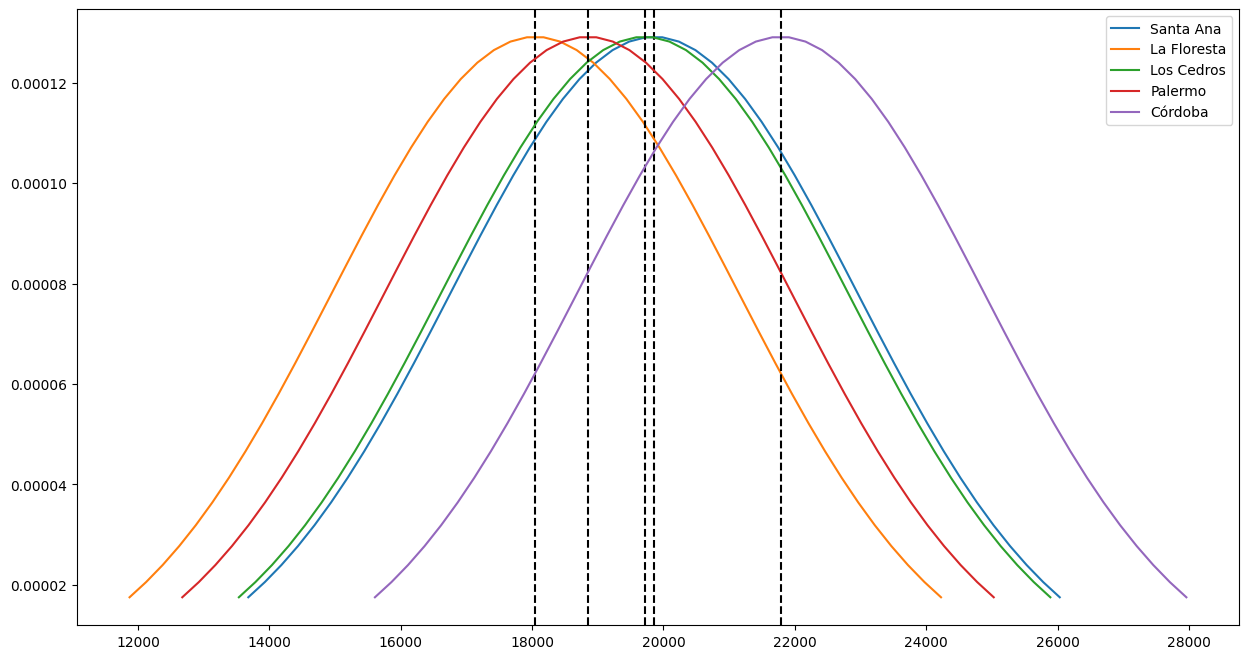

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

stores = ['Santa Ana', 'La Floresta', 'Los Cedros', 'Palermo', 'Córdoba']
sales_by_stores = [pd.read_excel('Datos_examen_final_17Co2024_Grupo4.xlsx', sheet_name=store)["Ventas"] for store in stores]
sigmas = [np.std(sales) for sales in sales_by_stores]
display(sigmas)
mean_sigma = np.mean(sigmas)
print('mean_sigma', mean_sigma)

fig, ax = plt.subplots(figsize=(15,8))   
for store, sales in zip(stores, sales_by_stores):
    μ = np.mean(sales)
    n = len(sales)
    # σ = np.std(sales)/np.sqrt(n)
    # ANOVA asume homocedasticidad (todas las desviaciones estandar son iguales)
    σ = mean_sigma
    x_axis = np.linspace(μ-2*σ,μ+2*σ)
    plt.plot(x_axis,norm.pdf(x_axis, μ, σ), label=store)
    plt.axvline(x=μ, ls='--', color='black')
plt.legend()
plt.show()

In [23]:
from scipy.stats import f_oneway
mus = [np.mean(sales) for sales in sales_by_stores]
sigmas = [mean_sigma for sales in sales_by_stores]
n = 100
samples = [np.random.normal(loc=mu, scale=sigma,size=n) for mu,sigma in zip(mus, sigmas)]
f_stat, p_value = f_oneway(*samples)

alpha = 0.05
print('f_stat:', f'{f_stat:.2f}')
print('p_value:', f'{p_value:.20f}')

if p_value < alpha:
    print("Rechazamos H0. Hay evidencia para afirmar que al menos una media es diferente")
else: 
    print("No se rehaza H0. Hay evidencia suficiente para afirmar que las medias son diferentes")

f_stat: 16.94
p_value: 0.00000000000050224130
Rechazamos H0. Hay evidencia para afirmar que al menos una media es diferente


## 3. Identifiquen la tienda con mayor promedio de ventas y la tienda con menor promedio de ventas y realicen una prueba de hipótesis para determinar si la diferencia entre ellas es distinta de 0 o no.

In [24]:
import pandas as pd
sheets = ['Santa Ana', 'La Floresta', 'Los Cedros', 'Palermo', 'Córdoba']
sales_by_sheets = [pd.read_excel('Datos_examen_final_17Co2024_Grupo4.xlsx', sheet_name=sheet)["Ventas"] for sheet in sheets]

mean_sales_by_sheets = [np.mean(sales) for sales in sales_by_sheets]
for i,sheet in enumerate(sheets):
    print(f'Promedio de ventas en {sheet}: {mean_sales_by_sheets[i]:.2f}')


Promedio de ventas en Santa Ana: 19856.50
Promedio de ventas en La Floresta: 18049.11
Promedio de ventas en Los Cedros: 19713.10
Promedio de ventas en Palermo: 18851.66
Promedio de ventas en Córdoba: 21784.30


In [27]:
min_mean_sales_sheet_idx = np.argmin(mean_sales_by_sheets)
max_mean_sales_sheet_idx = np.argmax(mean_sales_by_sheets)
min_mean_sales_sheet = sheets[min_mean_sales_sheet_idx]
max_mean_sales_sheet = sheets[max_mean_sales_sheet_idx]
print(f'Menor promedio de ventas en {min_mean_sales_sheet}')
print(f'Mayor promedio de ventas en {max_mean_sales_sheet}')

Menor promedio de ventas en La Floresta
Mayor promedio de ventas en Córdoba


H0:  mu1 = mu2

H1:  mu1 != m2 

Estadístico: -11.5282
Valor Crítico: 1.9600
Nivel de significancia: 0.05
Se rechaza H0. Hay evidencia suficiente para afirmar que las medias son diferentes


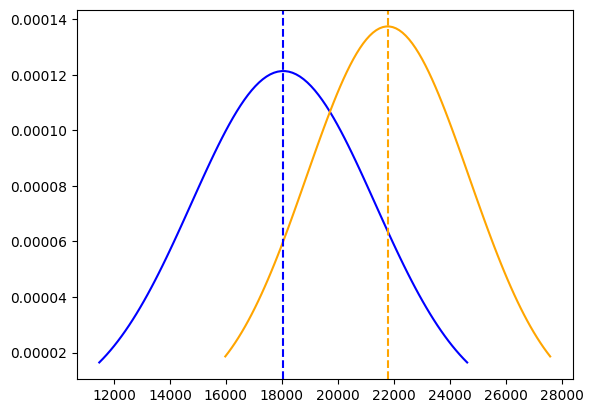

In [55]:
from scipy import stats
g1 = sales_by_sheets[min_mean_sales_sheet_idx]
g2 = sales_by_sheets[max_mean_sales_sheet_idx]

mu_g1 = np.mean(g1)
mu_g2 = np.mean(g2)
sigma_g1 = np.std(g1)/np.sqrt(len(g1))
sigma_g2 = np.std(g2)/np.sqrt(len(g2))

z_stat = (mu_g1-mu_g2)/(sigma_g1+sigma_g2)

alpha = 0.05

z_critico = stats.norm.ppf(1-alpha/2)

print(f'Estadístico: {z_stat:.4f}')
print(f'Valor Crítico: {z_critico:.4f}')
print(f'Nivel de significancia: {alpha}')
if abs(z_stat) > z_critico:
    print("Se rechaza H0. Hay evidencia suficiente para afirmar que las medias son diferentes")
else:
    print("No se rechaza H0. No hay evidencia suficiente para afirmar que las medias son diferentes")
    

x1 = np.linspace(mu_g1-2*np.std(g1),mu_g1+2*np.std(g1),100) 
x2 = np.linspace(mu_g2-2*np.std(g2),mu_g2+2*np.std(g2),100) 

y1 = stats.norm.pdf(x1, loc=mu_g1, scale=np.std(g1))
y2 = stats.norm.pdf(x2, loc=mu_g2, scale=np.std(g2))

plt.plot(x1,y1, label='Distribución grupo 1', color='blue')
plt.plot(x2,y2, label='Distribución grupo 2', color='orange')
plt.axvline(mu_g1, color='blue', linestyle='dashed')
plt.axvline(mu_g2, color='orange', linestyle='dashed')


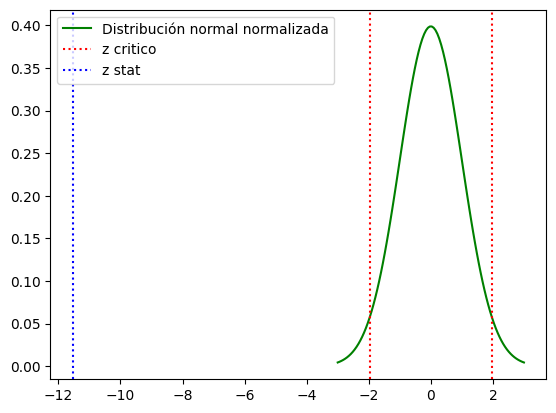

In [57]:
x = np.linspace(-3,3,100) 
y = stats.norm.pdf(x, loc=0, scale=1)
plt.plot(x,y, color='green', label='Distribución normal normalizada')
plt.legend()
plt.axvline(z_critico, color='red', linestyle='dotted', label='z critico')
plt.axvline(-z_critico, color='red', linestyle='dotted')
plt.axvline(z_stat, color='blue', linestyle='dotted', label='z stat')
plt.legend()

## 4. Determinen la distribución a posteriori del parámetro p de porcentaje de morosidad. Determinar su media y su varianza